In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time


def burst_waveform( time, amp ):
    A = amp
    B = 10.0
    C = 10.0
    omega = 1.2
    k = 1.0

    cosine_term   = A * math.cos( omega * time )      # oscillation
    heaviside_term = 1 / (1 + math.exp( -2*k*time ) ) # turn-on (heaviside step function parameterized)
    exponent_term = math.exp( -(time - B)/C )         # attenuation

    voltage = cosine_term * heaviside_term * exponent_term
    return voltage

def triangle_wave(time,amp):
    slope=1

    triangle_at_t= time *slope
    if triangle_at_t>amp:
        triangle_at_t= 2*amp -time*slope
    elif triangle_at_t<0:
        triangle_at_t=0

    return triangle_at_t


In [10]:

def trigger_v1(t_axis, signal_0, signal_1, max_size, alarm_0, alarm_1,alarm_m,delay_0, delay_1, delay_m ,delay_period, threshold, plot_size, trigger_times):
    signal_0 = signal_0[-max_size:]
    signal_1 = signal_1[-max_size:]

    if alarm_0.state==False and signal_0[-1]>threshold:
        alarm_0.set_true()

    elif alarm_0.state==True:
        delay_0.plus_one()
        if delay_0.value > delay_period:
            alarm_0.set_false()
            delay_0.reset()

    if alarm_1.state == False and signal_1[-1] > threshold:
        alarm_1.set_true()

    elif alarm_1.state == True:
        delay_1.plus_one()
        if delay_1.value > delay_period:
            alarm_1.set_false()
            delay_1.reset()


    if alarm_m.state == True:
        delay_m.plus_one()
        if delay_m.value > delay_period:
            delay_m.reset()
            alarm_m.set_false()
            print("Trigger condition reached!")

    if alarm_1.state * alarm_0.state and alarm_m.state ==False:
        alarm_m.set_true()
        delay_m.plus_one()



    if alarm_m.state==True and delay_m.value==1:
        #print("Trigger!", delay_m.value)
        trigger_time = t_axis[-1] + (plot_size / 2) #this records the times of triggers, and adds half of the plot_size to record the graph and have th triggered signals in the middle
        return np.append(trigger_times, trigger_time)
    else:
        return trigger_times


def save_trigger(t_axis, signal_0, signal_1, trigger_times, plot_size, threshold):

    last_time=t_axis[-1]
    if last_time==trigger_times[-1] :
        print("Plot ", last_time//200 , " is saved and plotted.")
        print("__________________________________________________")
        plt.subplot(2, 1, 1)
        plt.plot(t_axis[-plot_size:], signal_0[-plot_size:])
        plt.title("Random signal and random pulses")
        plt.ylabel("Voltage (mV) \n Channel 1")
        plt.axhline(y=threshold, color='r', lw=1, linestyle='--')
        plt.grid(True, lw=0.5)
        plt.text(1, 1.04, "Trigger \nconfirmed!", transform=plt.gca().transAxes, size=11, ha='right', va='bottom', color="green")

        plt.subplot(2, 1, 2)
        plt.plot(t_axis[-plot_size:], signal_1[-plot_size:])
        plt.xlabel("Time (ns)")
        plt.ylabel("Voltage (mV) \n Channel 2")
        plt.axhline(y=threshold, color='r', lw=1, linestyle='--')
        plt.grid(True, lw=0.5)
        plt.savefig(str(t_axis[-1]))
        plt.show()
    else:
        return None



In [11]:
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from waveform import burst_waveform


class random: #class for generating random numbers used as the amplitude of a signal
    def __init__(self, value):
        self.value=np.random.randint(35,150)
    def random(self):
        self.value=np.random.randint(35,150)

class markers: #this class is for counters used in generating the pulses
    def __init__(self, value):
        self.value=0
    def plus_one(self):
        self.value +=1
    def reset(self):
        self.value =0

class conditions(): #This is used for knowing if a pulse is happening and the code will keep generating the pulse if the value is True
    def __init__(self, state):
        self.state=False
    def set_true(self):
        self.state=True
    def set_false(self):
        self.state=False


def smart_append(t_axis,array,new_point,max_size):
    if t_axis[-1]<max_size:
        array=np.append(array,new_point)
    else:
        array=np.append(array[1:], new_point)
    return array

def random_generator( mean, std_dev, cond, cond_1, cond_2,wave_count,wave_count_1, wave_count_2, amp,amp_1,amp_2, likelihood):

    rand_point = np.random.normal(loc=mean, scale=std_dev) #this generates the background noise
    #rand_point=0

    """These if conditions are repeated 3 times. everytime it checks the "cond_*" condition to choose to generate a pulse"""

    """Pulse number 1 :"""
    if cond.state==False:
        signal = 0
        wave_count.reset()
        #amp=250
        if np.random.randint(likelihood*200)==likelihood-1:
            cond.set_true()

    else:
        #signal=triangle_wave(wave_count, amp)
        signal=burst_waveform(wave_count.value, amp.value)
        wave_count.plus_one()
        if wave_count.value>99:
            cond.set_false()
            amp.random()

    """Pulse number 2 :"""
    if cond_1.state==False:
        signal_1 = 0
        wave_count_1.reset()
        #amp=250
        if np.random.randint(likelihood*200)==likelihood-1:
            cond_1.set_true()

    else:
        #signal=triangle_wave(wave_count, amp)
        signal_1=burst_waveform(wave_count_1.value, amp_1.value)
        wave_count_1.plus_one()
        if wave_count_1.value>99:
            cond_1.set_false()
            amp_1.random()

    """Pulse number 3 :"""
    if cond_2.state == False:
        signal_2 = 0
        wave_count_2.reset()
        # amp=250
        if np.random.randint(likelihood*200)==likelihood-1:
            cond_2.set_true()

    else:
        #signal=triangle_wave(wave_count, amp)
        signal_2=burst_waveform(wave_count_2.value, amp_2.value)
        wave_count_2.plus_one()
        if wave_count_2.value>99:
            cond_2.set_false()
            amp_2.random()

    #This adds the noise to the 3 pulses
    next_point = rand_point + signal +signal_1 +signal_2
    return next_point


20000
Trigger condition reached!
Plot  4  is saved and plotted.
__________________________________________________


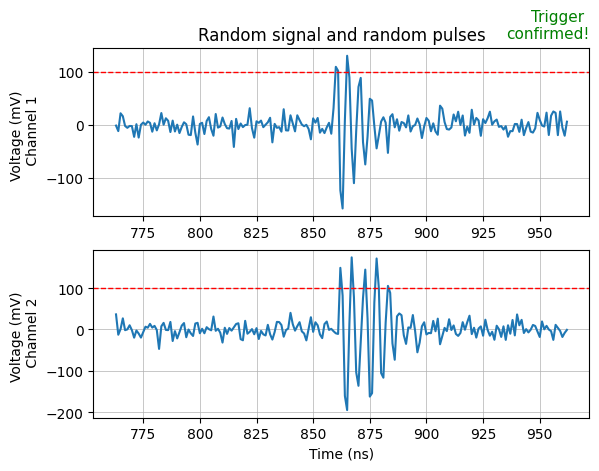

Trigger condition reached!
Plot  52  is saved and plotted.
__________________________________________________


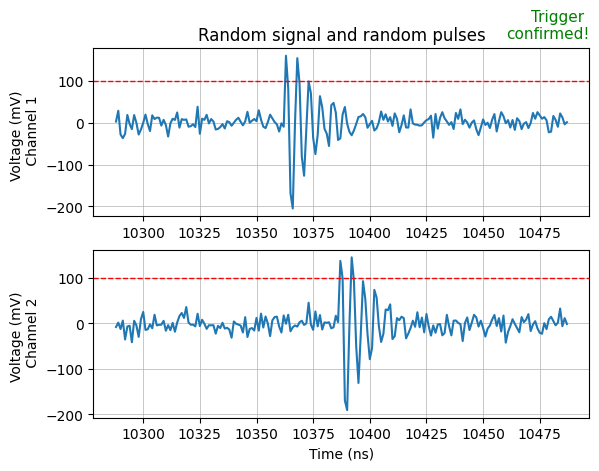

KeyboardInterrupt: 

In [12]:

#these are values used to generate noise
mean = 0
std_dev = 15

threshold = 100
delay_period= 30 #the delay of time to wait when a threshold is exceeded

n_runs=100 #this is the number of runs the program will go through, statistically it should trigger a few times if it has 100 runs.

t_axis = np.array([0])
signal_0 = np.array([0])
signal_1 = np.array([0])
trigger_times=np.array([0])

likelihood= 8 #probability of occurance of random pulses (Higher makes it less probable, 3 is around 1 occurance per cycle)
plot_size= 200 #Data points in one plot
max_size= 1000 #the maximum number of points in the signal arrays kept at any time (this includes t_axis)

#The classes are used to generate the simulated signals (everything is done 3 times)
amp,  amp_1,  amp_2         = random(np.random.randint(35,150)), random(np.random.randint(35,150)), random(np.random.randint(35,150))
wave_count, wave_count_1, wave_count_2 = markers(0),markers(0),markers(0)
cond,  cond_1,  cond_2      = conditions(False), conditions(False), conditions(False)

amp_1_0,  amp_1_1,  amp_1_2         = random(np.random.randint(35,150)), random(np.random.randint(35,150)), random(np.random.randint(35,150))
wave_count_1_0, wave_count_1_1, wave_count_1_2 = markers(0),markers(0),markers(0)
cond_1_0,  cond_1_1,  cond_1_2      = conditions(False), conditions(False), conditions(False)

#for the trigger system
alarm_0, alarm_1, alarm_m = conditions(False), conditions(False), conditions(False)
delay_0, delay_1, delay_m = markers(0), markers(0), markers(0)

#while True:
print(n_runs*plot_size)
for run in range(n_runs * plot_size):
    t_axis= smart_append(t_axis, t_axis, t_axis[-1]+1, max_size-1) #adds +1 to time each cycle, and limits the len(t_axis) to max_size

    Information_0 =random_generator(mean, std_dev, cond, cond_1, cond_2, wave_count, wave_count_1, wave_count_2,amp, amp_1, amp_2, likelihood)
    signal_0 = smart_append(t_axis, signal_0, Information_0, max_size)

    Information_1 = random_generator(mean, std_dev, cond_1_0, cond_1_1, cond_1_2, wave_count_1_0, wave_count_1_1, wave_count_1_2, amp_1_0 , amp_1_1 , amp_1_2, likelihood)
    signal_1 = smart_append(t_axis, signal_1, Information_1, max_size)

    #display_2_plots(t_axis, signal_0, signal_1, threshold, plot_size)

    #print(len(t_axis),len(signal_1),len( signal_0))
    trigger_times=trigger_v1(t_axis, signal_0, signal_1, max_size, alarm_0, alarm_1,alarm_m ,delay_0, delay_1, delay_m , delay_period, threshold, plot_size, trigger_times)
    save_trigger(t_axis, signal_0, signal_1, trigger_times, plot_size, threshold)
    time.sleep(0.000001)

print("The code ran successfully!")
